<a href="https://colab.research.google.com/github/nmonson1/mnist_exploration/blob/main/Copy_of_basin_broadness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from typing import Optional, Sequence, Iterable, Callable
from itertools import pairwise

import tqdm
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
print("torch version:", torch.__version__)

torch version: 2.0.1+cu118


In [ ]:
# Prepare data
batch_size = 512
trainloader = DataLoader(
    dataset=MNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor(),
    ),
    batch_size=batch_size,
    shuffle=True,
)
valloader = DataLoader(
    dataset=MNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor(),
    ),
    batch_size=batch_size,
    shuffle=False,
)

100%|██████████| 9912422/9912422 [00:00<00:00, 171948961.06it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 30854736.07it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 140939298.89it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12330439.33it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Verify batch size of input data
for tensor, label in trainloader:
    print(tensor.size(), label.size())
    break
# dim(tensor) = [B, 1, py, px]
# dim(label) = [B]

torch.Size([512, 1, 28, 28]) torch.Size([512])


In [ ]:
class FeedforwardClassifier(nn.Module):
    '''Very basic clasifier for MNIST.'''

    def __init__(
        self,
        *,
        input_dims: Iterable[int] = (1, 28, 28),
        hidden_dims: Optional[Sequence[int]] = None,
        n_classes: int = 10,
    ):
        super().__init__()
        if hidden_dims is None:
            hidden_dims = (5,)
        linear_dims = (np.prod(input_dims), *hidden_dims)
        self.layers = nn.Sequential(
            nn.Flatten(),
            *(
                get_layer()
                for d_in, d_out in pairwise(linear_dims)
                for get_layer in [
                    lambda: nn.Linear(d_in, d_out),
                    lambda: nn.ReLU(),
                ]
            ),
            nn.Linear(linear_dims[-1], n_classes),
        )

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        return self.layers(tensor)

In [ ]:
# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FeedforwardClassifier(hidden_dims=(5,)).to(device)
#model = ConvolutionalClassifier().to(device)
print(model)
print('No. of parameters:', sum(np.prod(p.size()) for p in model.parameters()))

FeedforwardClassifier(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=5, bias=True)
    (2): ReLU()
    (3): Linear(in_features=5, out_features=10, bias=True)
  )
)
No. of parameters: 3985


In [ ]:
# Set-up optimizer
weight_decay = 0.01


In [ ]:
# Train network
num_models=30
models = []
val_accs=[]
for m in range(num_models):
  print(m)
  model = FeedforwardClassifier(hidden_dims=(5,)).to(device)
  optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  n_epochs = 6
  with tqdm.tqdm(total=n_epochs * len(trainloader.dataset)) as pbar:
      model.train()
      for epoch in range(n_epochs):
          n_correct = 0
          n_samples = 0
          for x, label in trainloader:
              x, label = x.to(device), label.to(device)

              # Compute loss
              logits = model(x)
              loss = loss_fn(logits, label)

              n_samples += logits.size(0)
              n_correct += (logits.argmax(1) == label).sum().item()

              # Update weights
              loss.backward()
              optimizer.step()
              optimizer.zero_grad()
              pbar.update(logits.size(0))

          # Log progress
          pbar.write(f' Train acc: {n_correct / n_samples}')

          # Validation score
      n_correct = 0
      n_samples = 0
      model.eval()
      for x, label in valloader:
          x, label = x.to(device), label.to(device)

          # Compute loss
          with torch.no_grad():
              logits = model(x)

          n_samples += logits.size(0)
          n_correct += (logits.argmax(1) == label).sum().item()

      pbar.write(f' Val acc: {n_correct / n_samples}')
      val_accs.append(n_correct / n_samples)
      models.append(model)

0


 17%|█▋        | 60512/360000 [00:18<01:46, 2810.08it/s]

 Train acc: 0.44176666666666664


 34%|███▎      | 121024/360000 [00:32<00:39, 6082.89it/s]

 Train acc: 0.7266333333333334


 50%|█████     | 180512/360000 [00:43<00:31, 5775.00it/s]

 Train acc: 0.8007666666666666


 67%|██████▋   | 240512/360000 [00:53<00:19, 6147.06it/s]

 Train acc: 0.82505


 84%|████████▎ | 301024/360000 [01:04<00:10, 5505.14it/s]

 Train acc: 0.8380166666666666


100%|██████████| 360000/360000 [01:13<00:00, 6346.20it/s]

 Train acc: 0.8460333333333333


100%|██████████| 360000/360000 [01:15<00:00, 4747.82it/s]


 Val acc: 0.8502
1


 17%|█▋        | 60512/360000 [00:09<00:47, 6329.48it/s]

 Train acc: 0.3095


 33%|███▎      | 120512/360000 [00:20<00:39, 6085.75it/s]

 Train acc: 0.57945


 50%|█████     | 181024/360000 [00:31<00:31, 5763.59it/s]

 Train acc: 0.78385


 67%|██████▋   | 241024/360000 [00:42<00:21, 5466.35it/s]

 Train acc: 0.8113


 84%|████████▎ | 301024/360000 [00:53<00:09, 6027.03it/s]

 Train acc: 0.8214666666666667


100%|██████████| 360000/360000 [01:03<00:00, 4028.12it/s]

 Train acc: 0.82755


100%|██████████| 360000/360000 [01:05<00:00, 5509.71it/s]


 Val acc: 0.8345
2


 17%|█▋        | 60512/360000 [00:10<01:26, 3479.48it/s]

 Train acc: 0.3729166666666667


 33%|███▎      | 120512/360000 [00:20<00:39, 6088.90it/s]

 Train acc: 0.70275


 50%|█████     | 181024/360000 [00:31<00:30, 5961.82it/s]

 Train acc: 0.7997666666666666


 67%|██████▋   | 241024/360000 [00:41<00:19, 6197.40it/s]

 Train acc: 0.82935


 84%|████████▎ | 301024/360000 [00:51<00:09, 6150.16it/s]

 Train acc: 0.8438333333333333


100%|██████████| 360000/360000 [01:02<00:00, 5251.91it/s]

 Train acc: 0.8538833333333333


100%|██████████| 360000/360000 [01:03<00:00, 5658.89it/s]


 Val acc: 0.8586
3


 17%|█▋        | 60512/360000 [00:10<01:17, 3870.47it/s]

 Train acc: 0.41086666666666666


 33%|███▎      | 120512/360000 [00:20<00:39, 5987.37it/s]

 Train acc: 0.6599


 50%|█████     | 181024/360000 [00:30<00:29, 6041.14it/s]

 Train acc: 0.7826333333333333


 67%|██████▋   | 240512/360000 [00:41<00:19, 6162.43it/s]

 Train acc: 0.8131833333333334


 83%|████████▎ | 300512/360000 [00:51<00:10, 5799.93it/s]

 Train acc: 0.82785


100%|██████████| 360000/360000 [01:02<00:00, 4897.47it/s]

 Train acc: 0.8379333333333333


100%|██████████| 360000/360000 [01:03<00:00, 5658.75it/s]


 Val acc: 0.8476
4


 17%|█▋        | 60512/360000 [00:10<01:11, 4188.13it/s]

 Train acc: 0.36178333333333335


 34%|███▎      | 121024/360000 [00:20<00:38, 6238.84it/s]

 Train acc: 0.61295


 50%|█████     | 180512/360000 [00:30<00:29, 6016.38it/s]

 Train acc: 0.7044833333333334


 67%|██████▋   | 241024/360000 [00:41<00:20, 5917.82it/s]

 Train acc: 0.7729


 83%|████████▎ | 300512/360000 [00:51<00:10, 5901.67it/s]

 Train acc: 0.8068


100%|██████████| 360000/360000 [01:02<00:00, 5784.02it/s]

 Train acc: 0.8167166666666666


100%|██████████| 360000/360000 [01:03<00:00, 5644.88it/s]


 Val acc: 0.8237
5


 17%|█▋        | 60512/360000 [00:10<00:55, 5407.15it/s]

 Train acc: 0.3715


 33%|███▎      | 120512/360000 [00:20<00:50, 4702.72it/s]

 Train acc: 0.6423833333333333


 50%|█████     | 180512/360000 [00:30<00:28, 6190.26it/s]

 Train acc: 0.7346


 67%|██████▋   | 240512/360000 [00:41<00:19, 5985.60it/s]

 Train acc: 0.77675


 84%|████████▎ | 301024/360000 [00:52<00:09, 6117.09it/s]

 Train acc: 0.8021


100%|██████████| 360000/360000 [01:02<00:00, 6246.65it/s]

 Train acc: 0.81795


100%|██████████| 360000/360000 [01:04<00:00, 5612.38it/s]


 Val acc: 0.8254
6


 17%|█▋        | 61024/360000 [00:10<00:48, 6117.26it/s]

 Train acc: 0.4507333333333333


 33%|███▎      | 120512/360000 [00:20<00:58, 4106.47it/s]

 Train acc: 0.6331833333333333


 50%|█████     | 181024/360000 [00:31<00:29, 5981.35it/s]

 Train acc: 0.7614166666666666


 67%|██████▋   | 240512/360000 [00:41<00:19, 6018.66it/s]

 Train acc: 0.8259166666666666


 83%|████████▎ | 300512/360000 [00:52<00:09, 6198.58it/s]

 Train acc: 0.8487666666666667


100%|██████████| 360000/360000 [01:02<00:00, 6131.65it/s]

 Train acc: 0.8592


100%|██████████| 360000/360000 [01:04<00:00, 5583.92it/s]


 Val acc: 0.8631
7


 17%|█▋        | 60512/360000 [00:10<00:51, 5785.61it/s]

 Train acc: 0.3935666666666667


 34%|███▎      | 121024/360000 [00:21<00:44, 5349.91it/s]

 Train acc: 0.6191666666666666


 50%|█████     | 180512/360000 [00:31<00:32, 5600.81it/s]

 Train acc: 0.7632333333333333


 67%|██████▋   | 240512/360000 [00:41<00:20, 5718.87it/s]

 Train acc: 0.8075


 83%|████████▎ | 300512/360000 [00:52<00:10, 5658.30it/s]

 Train acc: 0.8215666666666667


100%|██████████| 360000/360000 [01:03<00:00, 5952.82it/s]

 Train acc: 0.8296


100%|██████████| 360000/360000 [01:05<00:00, 5536.93it/s]


 Val acc: 0.8378
8


 17%|█▋        | 60512/360000 [00:11<00:52, 5714.91it/s]

 Train acc: 0.28


 33%|███▎      | 120512/360000 [00:22<00:40, 5931.17it/s]

 Train acc: 0.6082166666666666


 50%|█████     | 180512/360000 [00:32<00:32, 5542.20it/s]

 Train acc: 0.7432333333333333


 67%|██████▋   | 241024/360000 [00:42<00:20, 5919.75it/s]

 Train acc: 0.7730166666666667


 84%|████████▎ | 301024/360000 [00:52<00:09, 6175.79it/s]

 Train acc: 0.7909


100%|██████████| 360000/360000 [01:03<00:00, 6447.55it/s]

 Train acc: 0.8036


100%|██████████| 360000/360000 [01:04<00:00, 5559.45it/s]


 Val acc: 0.8102
9


 17%|█▋        | 61024/360000 [00:10<00:49, 6065.53it/s]

 Train acc: 0.43848333333333334


 34%|███▎      | 121024/360000 [00:21<00:39, 6119.24it/s]

 Train acc: 0.7124666666666667


 50%|█████     | 181024/360000 [00:32<00:30, 5940.26it/s]

 Train acc: 0.7797166666666666


 67%|██████▋   | 240512/360000 [00:42<00:28, 4265.24it/s]

 Train acc: 0.81595


 84%|████████▎ | 301024/360000 [00:52<00:09, 5941.34it/s]

 Train acc: 0.8371333333333333


100%|██████████| 360000/360000 [01:03<00:00, 6144.73it/s]

 Train acc: 0.8506166666666667


100%|██████████| 360000/360000 [01:04<00:00, 5569.72it/s]


 Val acc: 0.8572
10


 17%|█▋        | 60000/360000 [00:10<00:48, 6143.31it/s]

 Train acc: 0.31543333333333334


 33%|███▎      | 120512/360000 [00:21<00:39, 6104.90it/s]

 Train acc: 0.6263833333333333


 50%|█████     | 181024/360000 [00:31<00:28, 6223.64it/s]

 Train acc: 0.7348166666666667


 67%|██████▋   | 240512/360000 [00:41<00:30, 3919.20it/s]

 Train acc: 0.77175


 83%|████████▎ | 300512/360000 [00:51<00:10, 5706.32it/s]

 Train acc: 0.7924666666666667


100%|██████████| 360000/360000 [01:02<00:00, 6367.00it/s]

 Train acc: 0.80525


100%|██████████| 360000/360000 [01:04<00:00, 5606.77it/s]


 Val acc: 0.8222
11


 17%|█▋        | 60512/360000 [00:10<00:50, 5977.96it/s]

 Train acc: 0.30743333333333334


 33%|███▎      | 120512/360000 [00:21<00:40, 5932.13it/s]

 Train acc: 0.5158333333333334


 50%|█████     | 180512/360000 [00:32<00:29, 5986.95it/s]

 Train acc: 0.6962166666666667


 67%|██████▋   | 241024/360000 [00:43<00:20, 5861.92it/s]

 Train acc: 0.8031833333333334


 83%|████████▎ | 300512/360000 [00:53<00:15, 3751.67it/s]

 Train acc: 0.8319333333333333


100%|██████████| 360000/360000 [01:03<00:00, 6072.00it/s]

 Train acc: 0.8423


100%|██████████| 360000/360000 [01:05<00:00, 5499.31it/s]


 Val acc: 0.8539
12


 17%|█▋        | 61024/360000 [00:10<00:51, 5801.27it/s]

 Train acc: 0.3794


 34%|███▎      | 121024/360000 [00:21<00:39, 6046.72it/s]

 Train acc: 0.6259


 50%|█████     | 180512/360000 [00:31<00:29, 6036.30it/s]

 Train acc: 0.7673166666666666


 67%|██████▋   | 241024/360000 [00:42<00:19, 5988.40it/s]

 Train acc: 0.8192166666666667


 84%|████████▎ | 301024/360000 [00:53<00:11, 5286.66it/s]

 Train acc: 0.8387166666666667


100%|██████████| 360000/360000 [01:02<00:00, 5043.22it/s]

 Train acc: 0.84895


100%|██████████| 360000/360000 [01:05<00:00, 5531.81it/s]


 Val acc: 0.8568
13


 17%|█▋        | 61024/360000 [00:09<00:48, 6156.53it/s]

 Train acc: 0.44958333333333333


 34%|███▎      | 121024/360000 [00:20<00:41, 5691.64it/s]

 Train acc: 0.6727166666666666


 50%|█████     | 181024/360000 [00:31<00:29, 6033.82it/s]

 Train acc: 0.7315333333333334


 67%|██████▋   | 240512/360000 [00:42<00:20, 5890.85it/s]

 Train acc: 0.7617833333333334


 84%|████████▎ | 301024/360000 [00:53<00:09, 5917.80it/s]

 Train acc: 0.7819166666666667


100%|██████████| 360000/360000 [01:03<00:00, 4309.58it/s]

 Train acc: 0.7985833333333333


100%|██████████| 360000/360000 [01:05<00:00, 5507.91it/s]


 Val acc: 0.8099
14


 17%|█▋        | 60512/360000 [00:10<01:21, 3674.29it/s]

 Train acc: 0.3300666666666667


 33%|███▎      | 120512/360000 [00:20<00:40, 5873.09it/s]

 Train acc: 0.5610166666666667


 50%|█████     | 180512/360000 [00:31<00:30, 5900.09it/s]

 Train acc: 0.7043


 67%|██████▋   | 241024/360000 [00:42<00:20, 5833.26it/s]

 Train acc: 0.8007666666666666


 84%|████████▎ | 301024/360000 [00:53<00:10, 5688.91it/s]

 Train acc: 0.8187666666666666


100%|██████████| 360000/360000 [01:03<00:00, 6346.77it/s]

 Train acc: 0.8240833333333333


100%|██████████| 360000/360000 [01:05<00:00, 5522.12it/s]


 Val acc: 0.8248
15


 17%|█▋        | 60512/360000 [00:10<00:52, 5737.64it/s]

 Train acc: 0.4290833333333333


 33%|███▎      | 120512/360000 [00:21<01:00, 3941.99it/s]

 Train acc: 0.63855


 50%|█████     | 180512/360000 [00:31<00:29, 6131.61it/s]

 Train acc: 0.7661


 67%|██████▋   | 241024/360000 [00:42<00:19, 6084.63it/s]

 Train acc: 0.7986166666666666


 83%|████████▎ | 300512/360000 [00:52<00:09, 6017.48it/s]

 Train acc: 0.81825


100%|██████████| 360000/360000 [01:03<00:00, 6123.76it/s]

 Train acc: 0.83175


100%|██████████| 360000/360000 [01:05<00:00, 5521.26it/s]


 Val acc: 0.8414
16


 17%|█▋        | 60512/360000 [00:10<00:50, 5915.13it/s]

 Train acc: 0.46595


 33%|███▎      | 120512/360000 [00:21<00:42, 5588.00it/s]

 Train acc: 0.62685


 50%|█████     | 180512/360000 [00:31<00:43, 4113.24it/s]

 Train acc: 0.7717333333333334


 67%|██████▋   | 240512/360000 [00:42<00:20, 5917.05it/s]

 Train acc: 0.8330666666666666


 83%|████████▎ | 300512/360000 [00:52<00:09, 5991.42it/s]

 Train acc: 0.85575


100%|██████████| 360000/360000 [01:03<00:00, 6215.54it/s]

 Train acc: 0.86415


100%|██████████| 360000/360000 [01:05<00:00, 5533.34it/s]


 Val acc: 0.8708
17


 17%|█▋        | 60512/360000 [00:10<00:52, 5696.96it/s]

 Train acc: 0.3774


 33%|███▎      | 120512/360000 [00:21<00:41, 5818.85it/s]

 Train acc: 0.6225333333333334


 50%|█████     | 180512/360000 [00:32<00:32, 5459.88it/s]

 Train acc: 0.7529833333333333


 67%|██████▋   | 240512/360000 [00:42<00:26, 4447.66it/s]

 Train acc: 0.7966166666666666


 84%|████████▎ | 301024/360000 [00:53<00:10, 5732.37it/s]

 Train acc: 0.8212


100%|██████████| 360000/360000 [01:03<00:00, 6239.27it/s]

 Train acc: 0.8389833333333333


100%|██████████| 360000/360000 [01:05<00:00, 5510.82it/s]


 Val acc: 0.8545
18


 17%|█▋        | 61024/360000 [00:10<00:50, 5896.58it/s]

 Train acc: 0.4273666666666667


 34%|███▎      | 121024/360000 [00:21<00:41, 5799.68it/s]

 Train acc: 0.67145


 50%|█████     | 181024/360000 [00:32<00:29, 6014.50it/s]

 Train acc: 0.74865


 67%|██████▋   | 240512/360000 [00:43<00:28, 4219.13it/s]

 Train acc: 0.7803666666666667


 83%|████████▎ | 300512/360000 [00:53<00:11, 5016.98it/s]

 Train acc: 0.7956333333333333


100%|██████████| 360000/360000 [01:03<00:00, 6318.45it/s]

 Train acc: 0.80995


100%|██████████| 360000/360000 [01:05<00:00, 5520.95it/s]


 Val acc: 0.8232
19


 17%|█▋        | 60512/360000 [00:10<00:49, 6073.99it/s]

 Train acc: 0.32935


 34%|███▎      | 121024/360000 [00:21<00:40, 5941.54it/s]

 Train acc: 0.5880666666666666


 50%|█████     | 181024/360000 [00:32<00:29, 6016.92it/s]

 Train acc: 0.6584


 67%|██████▋   | 241024/360000 [00:42<00:20, 5835.28it/s]

 Train acc: 0.6863


 83%|████████▎ | 300512/360000 [00:52<00:13, 4530.34it/s]

 Train acc: 0.7065666666666667


100%|██████████| 360000/360000 [01:02<00:00, 6608.38it/s]

 Train acc: 0.72435


100%|██████████| 360000/360000 [01:03<00:00, 5647.54it/s]


 Val acc: 0.7375
20


 17%|█▋        | 61024/360000 [00:10<00:48, 6184.97it/s]

 Train acc: 0.32721666666666666


 34%|███▎      | 121024/360000 [00:20<00:38, 6143.92it/s]

 Train acc: 0.61455


 50%|█████     | 181024/360000 [00:30<00:28, 6391.67it/s]

 Train acc: 0.7462833333333333


 67%|██████▋   | 240512/360000 [00:39<00:27, 4386.14it/s]

 Train acc: 0.8029333333333334


 83%|████████▎ | 300512/360000 [00:49<00:09, 6308.85it/s]

 Train acc: 0.8220666666666666


100%|██████████| 360000/360000 [00:59<00:00, 6482.47it/s]

 Train acc: 0.8344


100%|██████████| 360000/360000 [01:00<00:00, 5916.85it/s]


 Val acc: 0.8452
21


 17%|█▋        | 60512/360000 [00:10<00:47, 6340.52it/s]

 Train acc: 0.46745


 33%|███▎      | 120512/360000 [00:20<00:40, 5933.12it/s]

 Train acc: 0.7436833333333334


 50%|█████     | 181024/360000 [00:31<00:31, 5756.47it/s]

 Train acc: 0.7852833333333333


 67%|██████▋   | 240512/360000 [00:41<00:30, 3951.51it/s]

 Train acc: 0.80255


 84%|████████▎ | 301024/360000 [00:52<00:10, 5848.08it/s]

 Train acc: 0.8132


100%|██████████| 360000/360000 [01:02<00:00, 6208.01it/s]

 Train acc: 0.8210833333333334


100%|██████████| 360000/360000 [01:04<00:00, 5580.97it/s]


 Val acc: 0.835
22


 17%|█▋        | 60512/360000 [00:10<00:50, 5938.01it/s]

 Train acc: 0.32793333333333335


 33%|███▎      | 120512/360000 [00:21<00:41, 5797.40it/s]

 Train acc: 0.5917166666666667


 50%|█████     | 181024/360000 [00:32<00:30, 5878.40it/s]

 Train acc: 0.7646833333333334


 67%|██████▋   | 240512/360000 [00:42<00:24, 4896.23it/s]

 Train acc: 0.8081833333333334


 83%|████████▎ | 300000/360000 [00:52<00:08, 6723.93it/s]

 Train acc: 0.8222166666666667


100%|██████████| 360000/360000 [01:02<00:00, 6719.67it/s]

 Train acc: 0.8327333333333333


100%|██████████| 360000/360000 [01:03<00:00, 5641.76it/s]


 Val acc: 0.8402
23


 17%|█▋        | 61024/360000 [00:10<00:47, 6344.84it/s]

 Train acc: 0.31461666666666666


 34%|███▎      | 121024/360000 [00:19<00:37, 6419.81it/s]

 Train acc: 0.5738166666666666


 50%|█████     | 181024/360000 [00:30<00:29, 6096.67it/s]

 Train acc: 0.7501666666666666


 67%|██████▋   | 240512/360000 [00:38<00:18, 6308.08it/s]

 Train acc: 0.7899333333333334


 83%|████████▎ | 300512/360000 [00:48<00:09, 6435.77it/s]

 Train acc: 0.8063833333333333


100%|██████████| 360000/360000 [00:58<00:00, 6456.09it/s]

 Train acc: 0.8194833333333333


100%|██████████| 360000/360000 [01:00<00:00, 5969.16it/s]


 Val acc: 0.8323
24


 17%|█▋        | 60512/360000 [00:10<00:46, 6430.48it/s]

 Train acc: 0.36093333333333333


 34%|███▎      | 121024/360000 [00:20<00:39, 6121.37it/s]

 Train acc: 0.6689166666666667


 50%|█████     | 180512/360000 [00:29<00:30, 5814.81it/s]

 Train acc: 0.722


 67%|██████▋   | 241024/360000 [00:39<00:18, 6337.79it/s]

 Train acc: 0.7591166666666667


 84%|████████▎ | 301024/360000 [00:49<00:09, 6322.29it/s]

 Train acc: 0.7946


100%|██████████| 360000/360000 [00:59<00:00, 6589.19it/s]

 Train acc: 0.8169833333333333


100%|██████████| 360000/360000 [01:00<00:00, 5921.08it/s]


 Val acc: 0.8242
25


 17%|█▋        | 61024/360000 [00:10<00:48, 6146.38it/s]

 Train acc: 0.3198666666666667


 33%|███▎      | 120000/360000 [00:19<00:47, 5033.44it/s]

 Train acc: 0.6122


 50%|█████     | 181024/360000 [00:29<00:27, 6407.49it/s]

 Train acc: 0.7393166666666666


 67%|██████▋   | 241024/360000 [00:39<00:18, 6374.00it/s]

 Train acc: 0.8006833333333333


 84%|████████▎ | 301024/360000 [00:49<00:09, 6214.09it/s]

 Train acc: 0.8224666666666667


100%|██████████| 360000/360000 [00:59<00:00, 4418.33it/s]

 Train acc: 0.8318833333333333


100%|██████████| 360000/360000 [01:00<00:00, 5922.94it/s]


 Val acc: 0.8388
26


 17%|█▋        | 60512/360000 [00:09<01:10, 4240.72it/s]

 Train acc: 0.49068333333333336


 34%|███▎      | 121024/360000 [00:19<00:38, 6233.95it/s]

 Train acc: 0.7406666666666667


 50%|█████     | 180512/360000 [00:29<00:28, 6341.95it/s]

 Train acc: 0.7875333333333333


 67%|██████▋   | 241024/360000 [00:39<00:19, 6241.27it/s]

 Train acc: 0.80545


 84%|████████▎ | 301024/360000 [00:49<00:09, 5994.79it/s]

 Train acc: 0.8156833333333333


100%|██████████| 360000/360000 [00:59<00:00, 4674.46it/s]

 Train acc: 0.82425


100%|██████████| 360000/360000 [01:01<00:00, 5841.88it/s]


 Val acc: 0.8325
27


 17%|█▋        | 60512/360000 [00:09<00:48, 6112.91it/s]

 Train acc: 0.30241666666666667


 33%|███▎      | 120512/360000 [00:19<00:37, 6346.65it/s]

 Train acc: 0.5085166666666666


 50%|█████     | 180512/360000 [00:30<00:29, 6056.84it/s]

 Train acc: 0.66475


 67%|██████▋   | 240512/360000 [00:40<00:19, 6107.99it/s]

 Train acc: 0.7441833333333333


 83%|████████▎ | 300512/360000 [00:50<00:12, 4659.87it/s]

 Train acc: 0.7684833333333333


100%|██████████| 360000/360000 [00:59<00:00, 6115.41it/s]

 Train acc: 0.7789166666666667


100%|██████████| 360000/360000 [01:01<00:00, 5824.18it/s]


 Val acc: 0.784
28


 17%|█▋        | 61024/360000 [00:09<00:50, 5891.88it/s]

 Train acc: 0.4165333333333333


 33%|███▎      | 120512/360000 [00:20<00:38, 6238.01it/s]

 Train acc: 0.7214333333333334


 50%|█████     | 180512/360000 [00:30<00:29, 6103.17it/s]

 Train acc: 0.7839833333333334


 67%|██████▋   | 240512/360000 [00:40<00:21, 5590.25it/s]

 Train acc: 0.8035333333333333


 83%|████████▎ | 300512/360000 [00:51<00:15, 3887.29it/s]

 Train acc: 0.8162333333333334


100%|██████████| 360000/360000 [01:01<00:00, 5037.30it/s]

 Train acc: 0.8233166666666667


100%|██████████| 360000/360000 [01:03<00:00, 5691.19it/s]


 Val acc: 0.8298
29


 17%|█▋        | 60512/360000 [00:10<00:54, 5542.01it/s]

 Train acc: 0.42023333333333335


 33%|███▎      | 120512/360000 [00:20<00:39, 6081.08it/s]

 Train acc: 0.6968


 50%|█████     | 180512/360000 [00:31<00:28, 6234.08it/s]

 Train acc: 0.7559333333333333


 67%|██████▋   | 240512/360000 [00:41<00:19, 6157.66it/s]

 Train acc: 0.7840333333333334


 83%|████████▎ | 300512/360000 [00:52<00:13, 4277.92it/s]

 Train acc: 0.8014666666666667


100%|██████████| 360000/360000 [01:02<00:00, 4889.49it/s]

 Train acc: 0.8105166666666667


100%|██████████| 360000/360000 [01:04<00:00, 5591.04it/s]

 Val acc: 0.8191


## Basin broadness

In [ ]:
import functorch
hessloader = DataLoader(
    dataset=MNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor(),
    ),
    batch_size=60000,
    shuffle=True,
)

#par = func_params[-1]
volumes = []
for model in models:
  func, func_params = functorch.make_functional(model)
  for x, label in hessloader:

    def loss(params):
        out = func(func_params[:-1]+ (params,), x)
        return loss_fn(out, label)

    H=functorch.hessian(loss)((func_params[-1]))
    det = torch.det(H+torch.eye(10)*weight_decay)
    print(det)
    volume = 1/torch.sqrt(det)
    print(volume)
    volumes.append(volume)


/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:89: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.hessian is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.hessian instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  war

tensor(1.8534e-14, grad_fn=<LinalgDetBackward0>)
tensor(7345310., grad_fn=<MulBackward0>)
tensor(2.6048e-14, grad_fn=<LinalgDetBackward0>)
tensor(6196068.5000, grad_fn=<MulBackward0>)
tensor(1.7093e-14, grad_fn=<LinalgDetBackward0>)
tensor(7648741.5000, grad_fn=<MulBackward0>)
tensor(3.0527e-14, grad_fn=<LinalgDetBackward0>)
tensor(5723471., grad_fn=<MulBackward0>)
tensor(4.8766e-14, grad_fn=<LinalgDetBackward0>)
tensor(4528388., grad_fn=<MulBackward0>)
tensor(3.3291e-14, grad_fn=<LinalgDetBackward0>)
tensor(5480697., grad_fn=<MulBackward0>)
tensor(1.3142e-14, grad_fn=<LinalgDetBackward0>)
tensor(8723033., grad_fn=<MulBackward0>)
tensor(3.4022e-14, grad_fn=<LinalgDetBackward0>)
tensor(5421497.5000, grad_fn=<MulBackward0>)
tensor(6.0351e-14, grad_fn=<LinalgDetBackward0>)
tensor(4070579.5000, grad_fn=<MulBackward0>)
tensor(2.2828e-14, grad_fn=<LinalgDetBackward0>)
tensor(6618648., grad_fn=<MulBackward0>)
tensor(5.6682e-14, grad_fn=<LinalgDetBackward0>)
tensor(4200276., grad_fn=<MulBackwa

[tensor(7345310., grad_fn=<MulBackward0>), tensor(6196068.5000, grad_fn=<MulBackward0>), tensor(7648741.5000, grad_fn=<MulBackward0>), tensor(5723471., grad_fn=<MulBackward0>), tensor(4528388., grad_fn=<MulBackward0>), tensor(5480697., grad_fn=<MulBackward0>), tensor(8723033., grad_fn=<MulBackward0>), tensor(5421497.5000, grad_fn=<MulBackward0>), tensor(4070579.5000, grad_fn=<MulBackward0>), tensor(6618648., grad_fn=<MulBackward0>), tensor(4200276., grad_fn=<MulBackward0>), tensor(7183134.5000, grad_fn=<MulBackward0>), tensor(7460696.5000, grad_fn=<MulBackward0>), tensor(4656563.5000, grad_fn=<MulBackward0>), tensor(4091772.2500, grad_fn=<MulBackward0>), tensor(5878730.5000, grad_fn=<MulBackward0>), tensor(9526619., grad_fn=<MulBackward0>), tensor(6489226.5000, grad_fn=<MulBackward0>), tensor(4954165.5000, grad_fn=<MulBackward0>), tensor(1663564.7500, grad_fn=<MulBackward0>), tensor(6799346.5000, grad_fn=<MulBackward0>), tensor(5740739.5000, grad_fn=<MulBackward0>), tensor(6057948.5000

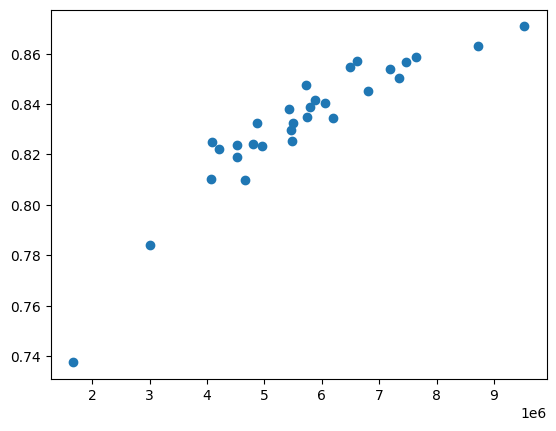

In [ ]:
import matplotlib.pyplot as plt
print(volumes)
print(val_accs)
plt.scatter([vol.detach() for vol in volumes],val_accs)

In [ ]:
get_basin_broadness(model, trainloader, loss_fn)



In [ ]:
state_values = tuple(model.state_dict().values())
state_dict = {k: v for k, v in zip(model.state_dict(), state_values)}
original_state_dict = model.state_dict()
model.load_state_dict(state_dict)
print(state)

In [ ]:



    output = model(x)
    loss = loss_fn(output, label)

    def func(model):
        return loss_fn(model(input), label)
    print(tuple(model.parameters()))
    hessian = torch.func.hessian(func, tuple(model.parameters()))

    print(hessian.size())
    det = torch.det(hessian)
    print(det.size())